## Base model is DenseNet121

In [ ]:
!pip install Keras-Preprocessing

In [ ]:
# @title Downloading
import os
import urllib.request
import zipfile


urls = {
    "train" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip",
    "train_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip",
    "validation" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip",
    "validation_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip",
    "test" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_Input.zip",
    "test_ground_truth" : "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Test_GroundTruth.zip"
    #"train_seg": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip",
    #"train_seg_gt": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Training_GroundTruth.zip",
    #"validation_seg": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip",
    #"validation_seg_gt": "https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip",

}

def download_all():
    for item in urls.items():
        name = item[0]
        url = item[1]
        filename = f"{name}.zip"
        if os.path.exists(filename):
            print(f"already exists file {filename}")
        else:
            print(f"downloading {filename} from {url} ...")
            urllib.request.urlretrieve(url, filename)
    print(f"done downloading all")

def unzip_all():
    for item in urls.items():
        name = item[0]
        url = item[1]
        filename = f"{name}.zip"
        print(filename)
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            print(f"unzipping {filename} to folder")
            zip_ref.extractall(f"{name}")


# if __name__ == "__main__":
#     download_all()
#     unzip_all()

download_all()
unzip_all()


In [3]:
%matplotlib inline
import tensorflow as tf
import keras as k
from keras import layers

from keras_preprocessing.image import ImageDataGenerator
from keras.models import clone_model
from keras.applications import ResNet50

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import cv2
import os
#import shutil

from PIL import Image

### Combine training dataset with validation dataset ( validation dataset is too small with only 193 images )

In [ ]:
!mkdir -p combined

In [ ]:
!cp ./train/ISIC2018_Task3_Training_Input/*.jpg ./combined/
!cp ./validation/ISIC2018_Task3_Validation_Input/*.jpg ./combined/

In [4]:
from glob import glob
print(len(glob('./combined/*.jpg')))

10208


In [5]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

train_df.sample(5)

,Unnamed: 0,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,bits_num,dx,image_file,dx_wt
1870,2922,ISIC_0027228,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,NV,ISIC_0027228.jpg,0.331113
4861,7626,ISIC_0031932,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,NV,ISIC_0031932.jpg,0.331113
5573,2440,ISIC_0026746,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,MEL,ISIC_0026746.jpg,0.888911
2100,8245,ISIC_0032551,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,NV,ISIC_0032551.jpg,0.331113
39,6296,ISIC_0030602,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,AKIEC,ISIC_0030602.jpg,0.967183


In [6]:
train_csv_path = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'
val_csv_path = 'validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv'

df1 = pd.read_csv(train_csv_path)
df2 = pd.read_csv(val_csv_path)

dfc = pd.concat([df1, df2])

dfc['bits_num'] = dfc['MEL'] * 1 + dfc['NV'] * 2 + dfc['BCC'] *4 + dfc['AKIEC']*8 +  \
    dfc['BKL']*16 + dfc['DF']*32 + + dfc['VASC']*64


labels = { 1.0 :"MEL", 2.0:"NV", 4.0:"BCC", 8.0:"AKIEC", 16.0:"BKL", 32.0:"DF", 64.0:"VASC" }

def to_dx(bits_num):
    return labels.get(bits_num)

dfc["dx"] = dfc["bits_num"].apply(to_dx)
dfc["image_file"] = dfc['image'] + '.jpg'

def compute_weights_lookup(the_df):
    total = the_df.shape[0]
    print(f"total = {total}")
    agg_df = the_df.groupby('dx').agg(sub_cnt = ('dx', 'count'))
    agg_df = agg_df.reset_index()
    lookup = {}
    for p in agg_df.to_numpy():
        label_name = p[0]
        label_count = p[1]
        lookup[label_name] = 1 - (  label_count / total )
    return lookup

weights_lookup = compute_weights_lookup(dfc)

weights_lookup

total = 10208


{'AKIEC': 0.9671826018808778,
 'BCC': 0.9481778996865203,
 'BKL': 0.8901841692789969,
 'DF': 0.9886363636363636,
 'MEL': 0.88891065830721,
 'NV': 0.3311128526645768,
 'VASC': 0.9857954545454546}

In [ ]:
# train_csv_path = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'
# val_csv_path = 'validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv'

# df1 = pd.read_csv(train_csv_path)
# df2 = pd.read_csv(val_csv_path)

# dfc = pd.concat([df1, df2])

# # print(dfc)

# dfc['bits_num'] = dfc['MEL'] * 1 + dfc['NV'] * 2 + dfc['BCC'] *4 + dfc['AKIEC']*8 +  \
#     dfc['BKL']*16 + dfc['DF']*32 + + dfc['VASC']*64


# labels = { 1.0 :"MEL", 2.0:"NV", 4.0:"BCC", 8.0:"AKIEC", 16.0:"BKL", 32.0:"DF", 64.0:"VASC" }

# def to_dx(bits_num):
#     return labels.get(bits_num)

# dfc["dx"] = dfc["bits_num"].apply(to_dx)
# dfc["image_file"] = dfc['image'] + '.jpg'

total_img_count = len(dfc)

train_img_count = total_img_count // 5 * 4
val_img_count = total_img_count - train_img_count

train_df = dfc.sample(train_img_count)

temp_list = train_df['image'].tolist()

val_df = dfc[~dfc['image'].isin(temp_list)]



def to_dx_weight(label_name):
    lbl_wt = weights_lookup.get(label_name)
    return 0 if lbl_wt is None else lbl_wt

train_df['dx_wt'] = train_df['dx'].apply(to_dx_weight)
val_df['dx_wt'] = val_df['dx'].apply(to_dx_weight)

# train_df.sample(5)
train_df.to_csv('train.csv')
val_df.to_csv('val.csv')

In [7]:
img_size = 128
labels_count = 7
do_batch_size = 128

In [8]:
# each func resturn a model for classification

def classification_densenet121(input_shape, output_num):
  inputs = layers.Input(shape=input_shape)
  #vgg19 = k.applications.VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
  #x = vgg19(inputs, training=False)
  densenet121 = k.applications.DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)
  x = densenet121(inputs, training=False)
  x = layers.Flatten()(x)
  # x = layers.Dense(128, activation="relu")(x)
  x = layers.Dense(img_size, activation="relu")(x)
  output = layers.Dense(output_num, activation="softmax")(x)

  model = k.Model(inputs=inputs, outputs=output, name="classification_densenet121")
  return model

def classification_vgg19(input_shape, output_num):
  inputs = layers.Input(shape=input_shape)
  vgg19 = k.applications.VGG19(include_top=False, weights="imagenet", input_tensor=inputs)
  x = vgg19(inputs, training=False)
  x = layers.Flatten()(x)
  # x = layers.Dense(128, activation="relu")(x)
  x = layers.Dense(img_size, activation="relu")(x)
  output = layers.Dense(output_num, activation="softmax")(x)

  model = k.Model(inputs=inputs, outputs=output, name="classification_vgg19")
  return model

##################################################################

# setup vgg19 ( ChaptGPT )
def get_vgg19_model(input_shape, output_num):
  from keras.applications import VGG19
  from keras.models import Model
  from keras.layers import Dense, Flatten
  #inputs = layers.Input(shape=input_shape)
  img_side_length = input_shape[0]
  base_model = VGG19(include_top=False, weights="imagenet", input_shape=input_shape)
  x = Flatten()(base_model.output)
  x = Dense(img_side_length, activation='relu')(x)
  output = Dense(output_num, activation='softmax')(x)  
  model = Model(inputs=base_model.input, outputs=output)
  # freeze pre-trained layers
  for layer in base_model.layers:
    layer.trainable = False

  #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

def get_densenet121_model(input_shape, output_num):
  from keras.applications import DenseNet121
  from keras.models import Model
  from keras.layers import Dense, Flatten
  #inputs = layers.Input(shape=input_shape)
  img_side_length = input_shape[0]
  base_model = DenseNet121(include_top=False, weights="imagenet", input_shape=input_shape)
  x = Flatten()(base_model.output)
  x = Dense(img_side_length, activation='relu')(x)
  output = Dense(output_num, activation='softmax')(x)  
  model = Model(inputs=base_model.input, outputs=output)
  # freeze pre-trained layers
  for layer in base_model.layers:
    layer.trainable = False

  return model

# generic model as suggested by chatgpt
def get_model(input_shape, output_num):
  from keras.models import Sequential
  from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
  model = Sequential()
  # Input layer and first Convolutional layer
  model.add(Conv2D(32, (3, 3), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # Additional Convolutional layers
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # Flattening the layers
  model.add(Flatten())
  # Fully connected layers
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10))  # Assuming 10 classes
  model.add(Activation('softmax'))
  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

##################################################################

def get_classification(input_shape, output_num):
  inputs = layers.Input(shape=input_shape)
  densenet = classification_densenet121(input_shape, output_num)(inputs)
  vgg19 = classification_vgg19(input_shape, output_num)(inputs)

  outputs = layers.average([densenet, vgg19])

  model = k.Model(inputs=inputs, outputs=outputs, name="ensemble.model")
  return model

#classification = get_classification((256,256,3), 2)
#classification = classification_vgg19((img_size, img_size, 3), labels_count)
classification = get_densenet121_model((img_size, img_size, 3), labels_count)
classification.summary()

#classification.save("classification.keras")

2024-02-14 00:41:34.878711: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 00:41:35.083725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 00:41:35.083791: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 00:41:35.085896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 00:41:35.085951: I external/local_xla/xla/stream_executor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 134, 134, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1/conv[0][0]']      

In [9]:
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

#weighted binary loss
def get_weights(labels):
    cols = len(labels.columns)-2 #assumes 1 column for image ids
    weights = {}
    for i in range(cols+1):
        weights[i] = 1-np.mean(labels[labels.columns[i+1]].tolist())
    return weights

print(get_weights(pd.read_csv(cls_train_gt)))

from keras import backend as K
def f_score(y_true, y_pred, threshold=0.1, beta=2):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (1+beta**2) * ((precision * recall) / ((beta**2)*precision + recall))

def tp_score(y_true, y_pred, threshold=0.1):
    tp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )
    tp = K.sum(K.cast(K.all(tp_3d, axis=1), 'int32'))
    return tp

def fp_score(y_true, y_pred, threshold=0.1):
    fp_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(K.abs(y_true - K.ones_like(y_true)))), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.greater(y_pred, K.constant(threshold)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=-1
    )

    fp = K.sum(K.cast(K.all(fp_3d, axis=1), 'int32'))
    return fp

def fn_score(y_true, y_pred, threshold=0.1):
    fn_3d = K.concatenate(
        [
            K.cast(K.expand_dims(K.flatten(y_true)), 'bool'),
            K.cast(K.expand_dims(K.flatten(K.abs(K.cast(K.greater(y_pred, K.constant(threshold)), 'float') - K.ones_like(y_pred)))), 'bool'),
            K.cast(K.ones_like(K.expand_dims(K.flatten(y_pred))), 'bool')
        ], axis=1
    )

    fn = K.sum(K.cast(K.all(fn_3d, axis=1), 'int32'))
    return fn

def precision_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fp = fp_score(y_true, y_pred, threshold)
    return tp / (tp + fp)

def recall_score(y_true, y_pred, threshold=0.1):
    tp = tp_score(y_true, y_pred, threshold)
    fn = fn_score(y_true, y_pred, threshold)
    return tp / (tp + fn)


{0: 0.888866699950075, 1: 0.3305042436345482, 2: 0.9486769845232151, 3: 0.9673489765351972, 4: 0.8902646030953569, 5: 0.9885172241637543, 6: 0.9858212680978532}


### 20 % for Validation instead of using isic validation dataset

In [10]:
cls_datagen = ImageDataGenerator(rotation_range=0,
                                horizontal_flip=True,
                                vertical_flip=True,
                                width_shift_range=0.15,
                                height_shift_range=0.15
                                )

# val_datagen = ImageDataGenerator(rotation_range=0,
#                                 horizontal_flip=True,
#                                 vertical_flip=True,
#                                 width_shift_range=0.15,
#                                 height_shift_range=0.15
#                                 )

In [11]:
# For loading classification labels and images.
# Standard Function, random sampling
def load_images_and_labels(images_path, labels_path, batch_size, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    data_indexes = []
    labels = pd.read_csv(labels_path)
    images = os.listdir(images_path)
    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path}")
    for i in range(batch_size):
        random_index = np.random.randint(0, len(images)-2)
        if random_index >= len(images):
            random_index -=1
        img = cv2.imread(os.path.join(images_path, images[random_index]))
        row = labels.iloc[random_index, 1:]

        if img is not None and row is not None:
            if random_index not in data_indexes:
                data_indexes.append(random_index)
                ds_images.append(np.array(cv2.resize(img, dsize=image_shape)))
                ds_labels.append(row.values)
    return np.array(ds_images).astype(np.int16), np.array(ds_labels).astype(np.int16)

# Equal Sampling
def load_images_and_labels_equal(images_path, labels_path, batch_size, num_classes, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    samples_per_class = []
    class_indexes = []
    labels = pd.read_csv(labels_path)
    class_names = np.array(labels.columns[1:])
    images = os.listdir(images_path)
    for i in range(num_classes):
        samples_per_class.append(batch_size//num_classes)
    for i in range(batch_size%num_classes):
        samples_per_class[i] += 1
    instances_per_class = labels.sum(axis=0, numeric_only=True)
    if verbose:
        print(f"loading images from {images_path} with equal sampling")
    for i in range(num_classes):
        #get all row indexes with 1 in ith row
        class_indexes = []
        p = 0
        for x in labels.iloc:
            if x[i+1] == 1:
                class_indexes.append(p)
            p+=1 #??? think i gotta remove this
        print(f"samples for {i} class: {samples_per_class[i]}, class_indexes len: {len(class_indexes)}")
        for x in range(samples_per_class[i]):
            random_index = np.random.randint(0, instances_per_class[i])
            ind = class_indexes[random_index]
            img = cv2.imread(os.path.join(images_path, images[ind]))
            row = labels.iloc[ind, 1:]
            if img is not None and row is not None:
                if not (samples_per_class[i] >= len(class_indexes)-1):
                    class_indexes.pop(random_index)
                    instances_per_class[i] -= 1
                ds_images.append(np.array(cv2.resize(img, dsize=image_shape), dtype="uint8"))
                #assuming 1 column for image id
                #ds_labels.append(row.values) #for array labels
                ds_labels.append(class_names[np.where(row.values == 1)[0][0]]) #for string labels - make sure to remove .astype for labels
                #ds_labels.append(np.where(row.values == 1)[0][0]) #for integer labels
        print("1 class loaded")
        print(f"len ds_images: {len(ds_images)}")
        print(f"len ds_labels: {len(ds_labels)}")
    return np.array(ds_images).astype(np.uint8), pd.get_dummies(ds_labels).to_numpy()#k.utils.to_categorical(ds_labels, num_classes=num_classes)


In [12]:
#classification = k.models.load_model('classification.keras') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0075)
classification.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", f_score, precision_score, 'AUC'])

callback_list = []#[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)] #can adjust to improve accuracy

seed = 123

cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

cls_train = r'train/ISIC2018_Task3_Training_Input/'#r"classi/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/"
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
#cls_train_gt_ham10000 = 'ham10000/HAM10000_metadata.csv'

epochs=40
batch_size = 8
spe=8
"""
length=len(pd.read_csv(cls_train_gt))//64
b_max= 60 # set this based on  how much your  memory can hold
batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and
                  length/n<=b_max],reverse=True)[0]
spe=int(length/batch_size)
"""

'\nlength=len(pd.read_csv(cls_train_gt))//64\nb_max= 60 # set this based on  how much your  memory can hold\nbatch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and\n                  length/n<=b_max],reverse=True)[0]\nspe=int(length/batch_size)\n'

In [13]:
cnt_err = 0
for fname in val_df['image_file'].to_list():
    if not os.path.exists(os.path.join('./combined/', fname)):
        cnt_err += 1

print(f"cnt_err={cnt_err}")
print(f"len(train_df)={len(train_df)}")
print(f"len(val_df)={len(val_df)}")

val_df.isnull().values.any()


cnt_err=0
len(train_df)=8164
len(val_df)=2044


False

In [14]:
#print(f"bs*spe*epochs = {batch_size*spe*epochs}")

#df_train= pd.read_csv(cls_train_gt_ham10000)
#df_validation = pd.read_csv

# MEL,NV,BCC,AKIEC,BKL,DF,VASC

# train_ds, train_gt = load_images_and_labels_equal(cls_train, cls_train_gt, batch_size*spe*epochs, labels_count, (img_size,img_size), True)
# val_ds, val_gt = load_images_and_labels_equal(cls_val, cls_val_gt, batch_size*spe*epochs//2, labels_count, (img_size,img_size), True)
#print(train_gt)

#train_data = cls_datagen.flow_from_dataframe(dataframe=df_train, directory=cls_train, x_col="image_id", y_col="dx", target_size=(256,256), batch_size=epochs*batch_size*spe, shuffle=True)
#validation_data = cls_datagen.flow_from_dataframe(dataframe=df, directory=cls_train, x_col="image_id", y_col="dx", target_size=(256,256), batch_size=epochs*batch_size*spe, shuffle=True)
#print(f"train_ds len: {len(train_ds)}, train labels len: {len(train_gt)}")
#print(f"val_ds len: {len(val_ds)}, val labels len: {len(val_gt)}")

# cls_train_gen = cls_datagen.flow(x=train_ds, y=train_gt, seed=seed, batch_size=batch_size*spe, shuffle=True)
# val_train_gen = cls_datagen.flow(x=val_ds, y=val_gt, seed=seed, batch_size=batch_size*spe//2, shuffle=True)



cls_train_gen = cls_datagen.flow_from_dataframe(train_df,
                                                    directory='./combined',
                                                    x_col='image_file',
                                                    y_col='dx',
                                                    weight_col='dx_wt',
                                                    target_size=(img_size, img_size),
                                                    batch_size=do_batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                    #subset='training',
                                                    seed=1)

val_train_gen = cls_datagen.flow_from_dataframe(dataframe=val_df,
                                                    directory='./combined',
                                                    x_col='image_file',
                                                    y_col='dx',
                                                    weight_col='dx_wt',
                                                    target_size=(img_size, img_size),
                                                    batch_size=do_batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                    #subset='validation',
                                                    seed=1)

#len(cls_train_gen.filenames)
# cls_train_gen = cls_datagen.flow_from_dataframe()
# cls_train_gen.class_indices  # {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}
val_train_gen.class_indices    # {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}

Found 8164 validated image filenames belonging to 7 classes.
Found 2044 validated image filenames belonging to 7 classes.


{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}

In [ ]:
# val_train_gen.samples  # 2044
# cls_train_gen.samples  # 81644
# val_train_gen.x  # error no x
# cls_train_gen.x  # error no x
# dir(cls_train_gen)
# cls_train_gen.batch_size  # 128
# cls_train_gen.allowed_class_modes   # {None, 'binary', 'categorical', 'input', 'multi_output', 'raw', 'sparse'}

#cls_train_gen.labels

# cls_train_gen.class_indices  # {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}
# val_train_gen.class_indices  # {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


In [ ]:
classification.summary()

In [15]:


# history = classification.fit(cls_train_gen, steps_per_epoch=len(cls_train_gen.x)//cls_train_gen.batch_size, epochs=epochs,
#                                 #class_weight=get_weights(pd.read_csv(cls_train_gt)),
#                                 batch_size=batch_size, callbacks=callback_list, verbose=1,
#                                 validation_data=(val_train_gen.x, val_train_gen.y), 
#                                 validation_steps=len(val_train_gen.x)//val_train_gen.batch_size)

# model.fit_generator(
#     train_generator,
#     steps_per_epoch = train_generator.samples // batch_size,
#     validation_data = validation_generator, 
#     validation_steps = validation_generator.samples // batch_size,
#     epochs = nb_epochs)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

new_class_weights = {}
for lbl in weights_lookup.keys():
    class_index = cls_train_gen.class_indices.get(lbl)
    new_class_weights[class_index] = 0 if class_index is None else weights_lookup[lbl]

print(f"new_class_weight = {new_class_weights}")

history = classification.fit(
                            cls_train_gen, 
                            epochs=epochs,
                            #class_weight=new_class_weights,
                            batch_size=do_batch_size, 
                            callbacks=callback_list, 
                            verbose=1,
                            validation_data=val_train_gen) 
                            # steps_per_epoch=cls_train_gen.samples//cls_train_gen.batch_size, 
                            # validation_steps=val_train_gen.samples//val_train_gen.batch_size)


print(f"--------------- Done training -----------------")

classification.save("classification_final.keras")


new_class_weight = {0: 0.9671826018808778, 1: 0.9481778996865203, 2: 0.8901841692789969, 3: 0.9886363636363636, 4: 0.88891065830721, 5: 0.3311128526645768, 6: 0.9857954545454546}
Epoch 1/40


2024-02-14 00:42:47.657196: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-14 00:42:47.773214: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-14 00:42:47.950187: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 1/64 [..............................] - ETA: 7:57 - loss: 3.3468 - accuracy: 0.6719 - f_score: 0.6907 - precision_score: 0.5974 - auc: 0.8379

2024-02-14 00:42:49.603839: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3df40fd2f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-14 00:42:49.603873: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
I0000 00:00:1707900169.650741  469552 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - 98s 1s/step - loss: 5.4289 - accuracy: 0.5601 - f_score: 0.5204 - precision_score: 0.2118 - auc: 0.7697 - val_loss: 0.7972 - val_accuracy: 0.6541 - val_f_score: 0.6205 - val_precision_score: 0.2639 - val_auc: 0.8972
Epoch 2/40
64/64 [==============================] - 85s 1s/step - loss: 0.7974 - accuracy: 0.6489 - f_score: 0.6273 - precision_score: 0.2853 - auc: 0.8869 - val_loss: 0.7711 - val_accuracy: 0.6546 - val_f_score: 0.6806 - val_precision_score: 0.3307 - val_auc: 0.9123
Epoch 3/40
64/64 [==============================] - 87s 1s/step - loss: 0.7838 - accuracy: 0.6395 - f_score: 0.6341 - precision_score: 0.2872 - auc: 0.8910 - val_loss: 0.7783 - val_accuracy: 0.6551 - val_f_score: 0.6847 - val_precision_score: 0.3407 - val_auc: 0.9118
Epoch 4/40
64/64 [==============================] - 84s 1s/step - loss: 0.7722 - accuracy: 0.6084 - f_score: 0.6417 - precision_score: 0.2915 - auc: 0.8939 - val_loss: 0.7992 - val_accuracy: 0.5827 - val_f_s

(450, 600, 3)
(128, 128, 3)
1/1 [==============================] - 3s 3s/step
True Label:            image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
71  ISIC_0034596  0.0  0.0  0.0    0.0  1.0  0.0   0.0
Predicted Scores: [[0.27164087 0.25449398 0.20569497 0.05498766 0.12484983 0.0710138
  0.01731888]]


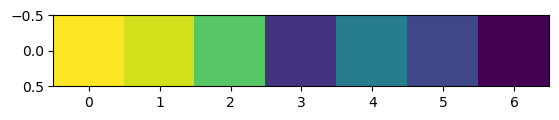

This image most likely belongs to MEL with a 27.16 percent confidence.


In [16]:
#Individual Image Testing
class_names=["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

pred_folder = "test/ISIC2018_Task3_Test_Input"
pred_image = "ISIC_0034596"
labels_path = "test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"
#classification = k.models.load_model("final_class.keras", custom_objects={"f_score": f_score, "precision_score": precision_score}) # make sure to run only after training the classification model


pred_label_df = pd.read_csv(labels_path)
pred_label_true = pred_label_df.loc[pred_label_df['image']==pred_image]

test_image = np.array(cv2.imread(os.path.join(pred_folder, pred_image) + ".jpg"))
print(test_image.shape)
#plt.imshow(test_image, interpolation='nearest')
#plt.show()

pred_image = cv2.resize(test_image, (img_size,img_size))
print(pred_image.shape)

img_array = tf.keras.utils.img_to_array(pred_image)
img_array = tf.expand_dims(img_array, 0) # Create a batch

score = classification.predict(img_array)
"""
TF_MODEL_FILE_PATH = 'cls_final_withresampling3.tflite' # The default path to the saved TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
sig_dict = interpreter.get_signature_list()
print(f"sig_dict = {sig_dict}")
sig = list(sig_dict)[0]
print(f'sig = {sig}')
classify_lite = interpreter.get_signature_runner('serving_default')
print(classify_lite)
predictions_lite = classify_lite(input_2=img_array)['dense_2']
score_lite = tf.nn.softmax(predictions_lite)
"""
label_name = class_names[np.argmax(score)]
confidence_percent = 100 * np.max(score)


print(f"True Label: {pred_label_true}")

print(f"Predicted Scores: {score}")
plt.imshow(score, interpolation="nearest")
plt.show()

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(label_name, confidence_percent))

Evaluation Graph Scripts

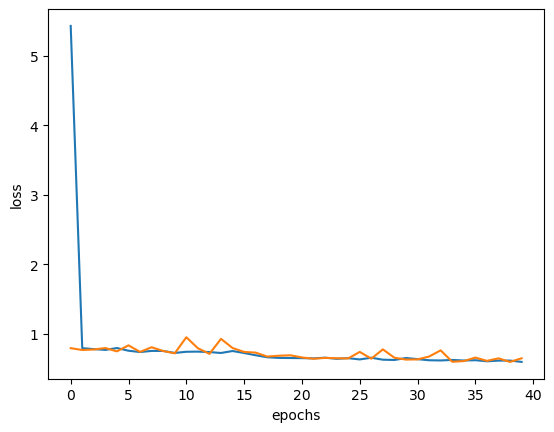

In [17]:
#eval
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
#train_acc  = history.history['acc']
#val_acc    = history.history['val_acc']
xc         = range(epochs)


plt.figure()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.show()

#plt.plot(xc, val_loss)

In [ ]:
# import keras
# #classification = keras.saving.load_model("vgg19_final.keras")
# classification = keras.saving.load_model("./saved_model/task3_vgg19_final")

In [18]:
def get_labels_dict(cls_indices):
    lookup = {}
    for k in cls_indices.keys():
        i = cls_indices[k]
        lookup[i] = k
    return lookup

labels_lookup = get_labels_dict(cls_train_gen.class_indices)
print(f"labels_lookup = {labels_lookup}")
print(f"cls_train_gen.class_indices = {cls_train_gen.class_indices}")

columns_indices = { 'MEL':1, 'NV':2, 'BCC':3, 'AKIEC':4, 'BKL':5, 'DF':6, 'VASC':7 }

def get_col_idx_to_class_idx():
    col_idx_to_class_idx = {}
    for lbl_key in cls_train_gen.class_indices.keys():
        column_idx = columns_indices[lbl_key]
        class_idx = cls_train_gen.class_indices[lbl_key]
        col_idx_to_class_idx[column_idx] = class_idx
    return col_idx_to_class_idx

col_idx_to_class_idx = get_col_idx_to_class_idx()

print(f"col_idx_to_class_idx = {col_idx_to_class_idx}")

labels_lookup = {0: 'AKIEC', 1: 'BCC', 2: 'BKL', 3: 'DF', 4: 'MEL', 5: 'NV', 6: 'VASC'}
cls_train_gen.class_indices = {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}
col_idx_to_class_idx = {4: 0, 3: 1, 5: 2, 6: 3, 1: 4, 2: 5, 7: 6}


In [19]:
# For loading classification labels and images.
# Standard Function, random sampling
def load_images_and_labels_2(images_path, labels_path, batch_size, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    #data_indexes = []
    labels_df = pd.read_csv(labels_path)
    #images = os.listdir(images_path)
    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path}")
    
    selected_df = labels_df.sample(batch_size)

    #for i in range(batch_size):
    for r_idx, row in selected_df.iterrows():
        # random_index = np.random.randint(0, len(images)-2)
        # if random_index >= len(images):
        #     random_index -=1
        # img = cv2.imread(os.path.join(images_path, images[random_index]))
        # row = labels_df.iloc[random_index, 1:]
        # if img is not None and row is not None:
        #     if random_index not in data_indexes:
        #         data_indexes.append(random_index)
        #         ds_images.append(np.array(cv2.resize(img, dsize=image_shape)))
        #         ds_labels.append(row.values)
        #print(f"row = {row}")
        img_file_name = row['image_file']
        dx_name = row['dx']
        dx_class_idx = cls_train_gen.class_indices[dx_name]
        dx_array = [ 1 if a == dx_class_idx else 0 for a in range(7)]
        img = cv2.imread(os.path.join(images_path, img_file_name))
        ds_images.append(np.array(cv2.resize(img, dsize=image_shape)))
        ds_labels.append(dx_array)

    return np.array(ds_images).astype(np.int16), np.array(ds_labels).astype(np.int16)

loading images from ./combined and labels from ./train.csv


Premature end of JPEG file
2024-02-14 01:41:20.515546: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 802553856 exceeds 10% of free system memory.
2024-02-14 01:41:21.140410: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 802553856 exceeds 10% of free system memory.


256/256 [==============================] - 7s 21ms/step


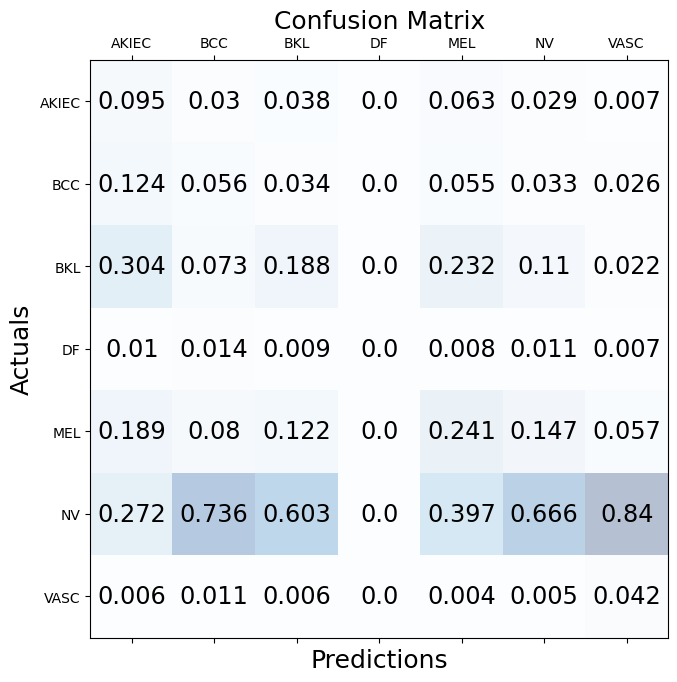

In [20]:
import matplotlib.ticker as mticker

def update_ticks(v, pos):
    vint = int(v)
    if 0 <= vint and vint <= 6:
        lbl = labels_lookup[vint]
        return lbl
    else:
        return v
    
# x_test_path = "test/ISIC2018_Task3_Test_Input"
# y_test_path = "test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"
x_test_path = "./combined"
y_test_path = "./train.csv"

x_test, y_test = load_images_and_labels_2(x_test_path, y_test_path, len(pd.read_csv(y_test_path)), (img_size,img_size), True)

y_prediction = classification.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(result, cmap=plt.cm.Blues, alpha=0.3)
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        ax.text(x=j, y=i,s=np.round(result[i, j], 3), va='center', ha='center', size='xx-large')

ax.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
# x_test_path = "test/ISIC2018_Task3_Test_Input"
# y_test_path = "test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"

# x_test, y_test = load_images_and_labels(x_test_path, y_test_path, len(pd.read_csv(y_test_path)), (img_size,img_size), True)

# y_prediction = classification.predict(x_test)
# y_prediction = np.argmax (y_prediction, axis = 1)
# y_test=np.argmax(y_test, axis=1)
# #Create confusion matrix and normalizes it over predicted (columns)
# result = confusion_matrix(y_test, y_prediction , normalize='pred')
# fig, ax = plt.subplots(figsize=(7.5, 7.5))
# ax.matshow(result, cmap=plt.cm.Blues, alpha=0.3)
# for i in range(result.shape[0]):
#     for j in range(result.shape[1]):
#         ax.text(x=j, y=i,s=np.round(result[i, j], 3), va='center', ha='center', size='xx-large')

# plt.xlabel('Predictions', fontsize=18)
# plt.ylabel('Actuals', fontsize=18)
# plt.title('Confusion Matrix', fontsize=18)
# plt.show()

In [ ]:
# def convert_to_tflite(model, name):
#     converter = tf.lite.TFLiteConverter.from_keras_model(model)
#     tflite_model = converter.convert()

#     # Save the model.
#     with open(str(name), 'wb') as f:
#       f.write(tflite_model)

In [ ]:
# classification

In [ ]:
#convert_to_tflite(classification, "cls_final.tflite")

In [21]:
#classification.save("classification_final.keras")
classification.save("densenet121_final.keras")

In [22]:
#classification.save("saved_model/task3_final")
classification.save("saved_model/task3_densenet121_final")

INFO:tensorflow:Assets written to: saved_model/task3_densenet121_final/assets


INFO:tensorflow:Assets written to: saved_model/task3_densenet121_final/assets


In [ ]:
!zip -r saved_model.zip /content/saved_model

In [23]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model/task3_densenet121_final") # path to the SavedModel directory
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()
tflite_model = converter.convert()

# Save the model.
with open('./densenet121.tflite', 'wb') as f:
  f.write(tflite_model)

2024-02-14 01:43:00.408568: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-14 01:43:00.408609: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-14 01:43:00.416774: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ./saved_model/task3_densenet121_final
2024-02-14 01:43:00.445909: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-14 01:43:00.445933: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: ./saved_model/task3_densenet121_final
2024-02-14 01:43:00.514733: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-14 01:43:00.543258: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-14 01:43:01.255733: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedMode

In [24]:
test_csv_path = "test_ground_truth/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv"
test_images_path = "test/ISIC2018_Task3_Test_Input"

test_df = pd.read_csv(test_csv_path)

def get_bitsnum(df):
    df['bits_num'] = df['MEL'] * 1 + df['NV'] * 2 + df['BCC'] *4 + df['AKIEC']*8 + \
        df['BKL']*16 + df['DF']*32 + + df['VASC']*64
    return df

test_df = get_bitsnum(test_df)

labels = { 1.0 :"MEL", 2.0:"NV", 4.0:"BCC", 8.0:"AKIEC", 16.0:"BKL", 32.0:"DF", 64.0:"VASC" }

def to_dx(bits_num):
    return labels.get(bits_num)

def get_dx_fname(df):
    df["dx"] = df["bits_num"].apply(to_dx)
    df["image_file"] = df['image'] + '.jpg'
    return df

test_df = get_dx_fname(test_df)

total_img_count = len(test_df)

print(total_img_count)

print(test_df.sample(5))

# cls_train_gen.class_indices # {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}

def get_labels_dict(cls_indices):
    lookup = {}
    for k in cls_indices.keys():
        i = cls_indices[k]
        lookup[i] = k
    return lookup

labels_lookup = get_labels_dict(cls_train_gen.class_indices)
print(f"labels_lookup = {labels_lookup}")

from keras.preprocessing import image

def get_inf(fname):
    # img = cv2.imread(os.path.join(test_images_path, fname))
    # img_temp = np.array(cv2.resize(img, dsize=(img_size, img_size)))
    img = image.load_img(os.path.join(test_images_path, fname), target_size=(img_size, img_size))  # Resize the image to match model's input size
    img_array = image.img_to_array(img)  # Convert PIL image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    inferred = classification.predict(img_array, verbose=0)
    predicted_index = np.argmax(inferred)
    #print("Predicted class index:", predicted_index)
    lbl = labels_lookup[predicted_index]
    #print(inferred.tolist())
    confidence = inferred[0][predicted_index]
    return lbl, confidence

cnt_wrong = 0
test_results = []
for row_index, row in test_df.iterrows():
    lbl, confidence = get_inf(row['image_file'])
    img_fname = row["image_file"]
    expected_dx = row["dx"]
    is_correct = True
    #print(f"{img_name} predicted label = {lbl} with confidence {confidence}, expected = {expected_dx}")
    if expected_dx != lbl:
        #print(f"expected={expected_dx} , lbl={lbl}")
        is_correct = False
        cnt_wrong += 1
    test_results.append([confidence, is_correct, img_fname])

accuracy_pct = cnt_wrong / len(test_df)
accuracy_pct = accuracy_pct * 100
print(f"accuracy = {accuracy_pct} %")

1512
             image  MEL   NV  BCC  AKIEC  BKL   DF  VASC  bits_num   dx  \
1213  ISIC_0035766  1.0  0.0  0.0    0.0  0.0  0.0   0.0       1.0  MEL   
1436  ISIC_0035989  0.0  1.0  0.0    0.0  0.0  0.0   0.0       2.0   NV   
839   ISIC_0035385  0.0  1.0  0.0    0.0  0.0  0.0   0.0       2.0   NV   
976   ISIC_0035526  0.0  1.0  0.0    0.0  0.0  0.0   0.0       2.0   NV   
862   ISIC_0035408  0.0  1.0  0.0    0.0  0.0  0.0   0.0       2.0   NV   

            image_file  
1213  ISIC_0035766.jpg  
1436  ISIC_0035989.jpg  
839   ISIC_0035385.jpg  
976   ISIC_0035526.jpg  
862   ISIC_0035408.jpg  
labels_lookup = {0: 'AKIEC', 1: 'BCC', 2: 'BKL', 3: 'DF', 4: 'MEL', 5: 'NV', 6: 'VASC'}
accuracy = 40.80687830687831 %


## Most Confused and Incorrect Predictions

In [25]:
result_df = pd.DataFrame(test_results)
result_df.columns = ['confidence', 'is_right', 'filename']

result_df = result_df.sort_values(by='confidence', ascending=True)

selected_df = result_df[result_df['is_right'] == False].head(12)

def get_dx(fname):
    df = test_df[test_df['image_file'] == fname]
    dx_value = df['dx'].to_list()[0]
    return dx_value

# sname = 'ISIC_0034952.jpg'
# get_dx(sname)['dx'].to_list()[0]
selected_df['dx'] = selected_df['filename'].apply(get_dx)

selected_df

,confidence,is_right,filename,dx
1080,0.178251,False,ISIC_0035633.jpg,VASC
871,0.184368,False,ISIC_0035417.jpg,NV
182,0.191448,False,ISIC_0034709.jpg,NV
1103,0.193001,False,ISIC_0035656.jpg,NV
760,0.206039,False,ISIC_0035305.jpg,BCC
908,0.223477,False,ISIC_0035456.jpg,NV
448,0.228554,False,ISIC_0034982.jpg,AKIEC
522,0.229094,False,ISIC_0035056.jpg,NV
1407,0.233266,False,ISIC_0035960.jpg,BCC
537,0.235729,False,ISIC_0035072.jpg,BCC


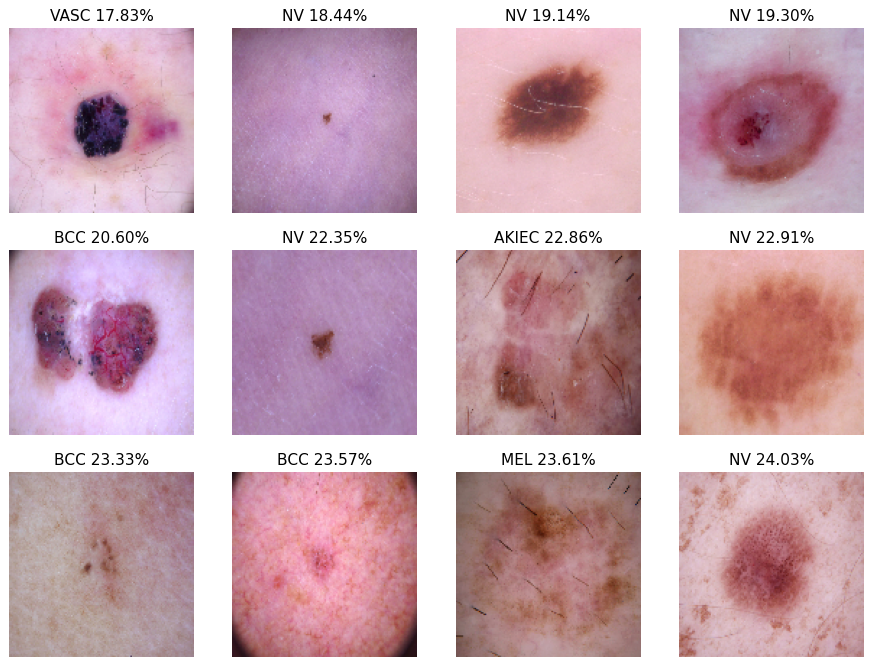

In [26]:
import cv2
from keras.preprocessing import image

fig = plt.figure(figsize=(12, 12), dpi=92)   # 1080p 24" monitor
graph_rows = 4
graph_columns = 4

gr_idx = 1
for idx, plot_row in selected_df.iterrows():
    fname = plot_row['filename']
    confidence = plot_row['confidence']
    confid_str = f"{confidence * 100:.2f}"
    dx = plot_row["dx"]
    #the_img = cv2.read(os.path.join('./combined', fname))
    the_img = image.load_img(os.path.join('./test/ISIC2018_Task3_Test_Input', fname), target_size=(img_size, img_size))
    fig.add_subplot(graph_rows, graph_columns, gr_idx)
    plt.imshow(the_img)
    plt.axis('off')
    plt.title(f"{dx} {confid_str}%")

    gr_idx += 1


### Testing tfite model loading

In [27]:
print(cls_train_gen.class_indices)

labels_lookup = get_labels_dict(cls_train_gen.class_indices)

print(labels_lookup)

{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}
{0: 'AKIEC', 1: 'BCC', 2: 'BKL', 3: 'DF', 4: 'MEL', 5: 'NV', 6: 'VASC'}


In [29]:
def processImg(img_path):
    img_height = 128
    img_width = 128
    img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    #my_dir = os.path.dirname(__file__)
    m_name = os.path.join("./", 'densenet121.tflite')
    # TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model
    TF_MODEL_FILE_PATH = m_name
    interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
    sig_dict = interpreter.get_signature_list()
    print(f"sig_dict = {sig_dict}")
    sig = list(sig_dict)[0]
    #print(f'sig = {sig}')
    classify_lite = interpreter.get_signature_runner('serving_default')
    #print(classify_lite)
    
    # predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']

    predictions_lite = classify_lite(input_1=img_array)['dense_1']
    print(predictions_lite)
    score_lite = tf.nn.softmax(predictions_lite)
    print(score_lite)
    print(np.argmax(score_lite))
    label_name = labels_lookup[np.argmax(score_lite)]
    confidence_percent = 100 * np.max(score_lite)
    print("This image {} most likely belongs to {} with a {:.2f} percent confidence.".format(img_path, label_name, confidence_percent))

    return label_name, confidence_percent

# /home/danny/work/Simple_Classification_Test/test/ISIC2018_Task3_Test_Input/ISIC_0034524.jpg
lb_name, confid = processImg('./test/ISIC2018_Task3_Test_Input/ISIC_0034524.jpg')
print(f"{lb_name}, {confid}")

sig_dict = {'serving_default': {'inputs': ['input_1'], 'outputs': ['dense_1']}}
[[4.1226685e-04 6.5720258e-03 3.1022537e-03 1.1004100e-02 1.6908541e-04
  9.4537050e-01 3.3369806e-02]]
tf.Tensor(
[[0.11593546 0.11665178 0.11624773 0.11716995 0.11590727 0.2982678
  0.11982006]], shape=(1, 7), dtype=float32)
5
This image ./test/ISIC2018_Task3_Test_Input/ISIC_0034524.jpg most likely belongs to NV with a 29.83 percent confidence.
NV, 29.826781153678894


In [ ]:
# import numpy as np
# from keras.preprocessing import image
# from keras.models import load_model

# # Load the pre-trained model
# model = load_model('your_model.h5')

# # Define the image path
# image_path = 'your_image.jpg'

# # Preprocess the image
# img = image.load_img(image_path, target_size=(224, 224))  # Resize the image to match model's input size
# img_array = image.img_to_array(img)  # Convert PIL image to numpy array
# img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
# img_array /= 255.  # Normalize pixel values between 0 and 1

# # Perform prediction
# predictions = model.predict(img_array)

# # Decode the predictions
# # Here you'll need to implement the decoding logic based on your specific model and problem (e.g., using class labels)
# # This could involve mapping prediction indices to class labels or categories

# # Example: Get the index with the highest probability
# predicted_index = np.argmax(predictions)
# print("Predicted class index:", predicted_index)

# # Example: Assuming you have a list of class labels
# class_labels = ['class1', 'class2', 'class3']  # Example list of class labels
# predicted_class = class_labels[predicted_index]
# print("Predicted class:", predicted_class)
